In [1]:
#General
import numpy as np
import pandas as pd

#Data Retrieval and Visualization
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

#Statistical Package
from scipy import stats 
from numpy import log10, polyfit, var, subtract
from statsmodels import regression
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts


In [2]:
spy_etf=web.DataReader('SPY','yahoo','1993-01-01','2017-01-01' ) 

In [3]:
#spy_etf.reset_index(drop=True,inplace=True)
spy_etf.head()


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1993-01-29,43.96875,43.75000,43.96875,43.93750,1003200.0,26.184059
1993-02-01,44.25000,43.96875,43.96875,44.25000,480500.0,26.370279
1993-02-02,44.37500,44.12500,44.21875,44.34375,201300.0,26.426161
1993-02-03,44.84375,44.37500,44.40625,44.81250,529400.0,26.705482
1993-02-04,45.09375,44.46875,44.96875,45.00000,531500.0,26.817228


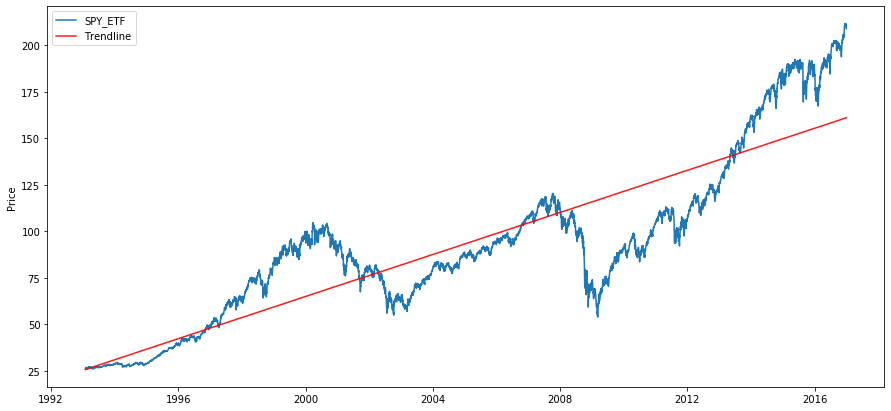

In [5]:
plt.figure(figsize=(15,7))
plt.plot(spy_etf['Adj Close'])

# Find the line of best fit to illustrate the trend
X = np.arange(len(spy_etf['Adj Close'].index))
x = sm.add_constant(X) # Add a column of ones so that line can have a y-intercept
model = regression.linear_model.OLS(spy_etf['Adj Close'], x).fit()
a = model.params[0] # Get coefficients of line
b = model.params[1]
spy_etf['Y_hat'] = X * b + a
plt.plot(spy_etf['Y_hat'], 'r', alpha=0.9);
plt.ylabel('Price')
plt.legend(['SPY_ETF', 'Trendline']);
plt.show()

## ADF Test for Stationary
Null Hypothesis: The series has a unit root 

Alternate Hypothesis: The series has no unit root. [Stationary]



In [130]:
def adf_test(ticker):
    #Perform Augmented Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    adf_test = adfuller(np.log(ticker), autolag='AIC')
    dfoutput = pd.Series(adf_test[0:4], index=['Test Statistic','P-value','#Lags Used','Number of Observations Used'])
    for key,value in adf_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series

adf_test(spy_etf['Adj Close'])


Results of Dickey-Fuller Test:
Test Statistic                   -1.280494
P-value                           0.638048
#Lags Used                       34.000000
Number of Observations Used    5991.000000
Critical Value (1%)              -3.431442
Critical Value (5%)              -2.862023
Critical Value (10%)             -2.567027
dtype: float64


ADF Test statistics is always positive for trend following and negative for mean reversion. We can also see the p-value is 0.881719,means it is non stationary.
Since your adfuller P-value is higher than a certain specified alpha (i.e.: 5%), then you fail reject the null hypothesis (Ho), because the probability of getting a P-value as high as that by mere luck (random chance) is very likely.

# Finding Correlations between Returns of Different Time Frames
Null Hypothesis: No Correlation

Alternative Hypothesis: Correlation

P-value represent the probability for the null hyptohesis. Find the optimal pair of past and future periods that give highest positive correlation

In [143]:
def correlation_Opt(ts):
    ts.reset_index(drop=True,inplace=True)
    lookback=[5,10,25,60,120,180,250]
    holddays =[5,10,25,60,120,180,250]
    print("Look-back"," Holding days","Correlation Coefficient","P-Value",sep="     ")
    for look in lookback:
        for hold in holddays:
           #Lag and Fut return
            ret_lag=(ts-ts.shift(look))/ts.shift(look)
            ret_fut=(ts.shift(-hold)-ts)/ts
            #Remove row with nan values
            df=pd.concat([ret_lag,ret_fut],axis=1)
            df.columns=['lag','fut']
            df.dropna(inplace=True)
            df.reset_index(drop=True,inplace=True)
            ret_lag=df['lag']
            ret_fut=df['fut']
            #Remove overlapping data 
            if (look>=hold):
                indepSet=np.arange(0,len(ret_lag)+1,look)
            else:
                indepSet=np.arange(0,len(ret_lag)+1,hold)
            
            ret_lag=ret_lag[indepSet]
            ret_fut=ret_fut[indepSet]
            cor,p_val=stats.pearsonr(ret_lag,ret_fut)
            print(look,"             ", hold,"           ",cor, "         ",p_val)
    
correlation_Opt(spy_etf['Adj Close'])

Look-back      Holding days     Correlation Coefficient     P-Value
5               5             -0.05595777220082776           0.05223809800240198
5               10             -0.09363641371943712           0.021578358746910047
5               25             -0.14330696311985164           0.026419989135815527
5               60             0.07569634554225989           0.45414572345846527
5               120             0.02993175366996694           0.8365234622073509
5               180             0.3896890370800795           0.02497877255394278
5               250             -0.09038141757075788           0.6744846576644051
10               5             0.03079194039160184           0.4507831470269081
10               10             -0.029858752663492628           0.46500193290522984
10               25             -0.054254638092759155           0.4027401089734386
10               60             -0.035386839046289004           0.7266922844525221
10               120          

As can be seen, there is a compromise between correlation coefficient and p-value

## Hurst Exponent
Hurst exponent $H$ indicates whether a time series is stationary ($H<0.5$), random ($H=0.5$), or trending ($H>0.5$)

In [137]:
from numpy import log10, polyfit, var, subtract

def hurst_function(ts, lag_range=None):
    ts = ts if not isinstance(ts, pd.Series) else ts.to_list()
    ts = log10(ts) # use log price

    variancetau = []
    tau = []
    
    #  Range of lag values
    if lag_range == None:
        lags = [2]
    else:
        lags = range(2, lag_range) # lag_range < len(ts)

    for lag in lags: 

        #  Write the different lags into a vector to compute a set of tau or lags
        tau.append(lag)

        # The price difference
        pp = subtract(ts[lag:], ts[:-lag])
        variancetau.append(var(pp))

    # Plot the log of corrseponding variance against the log of tau and get the slope
    m = polyfit(log10(tau),log10(variancetau),1)

    hurst = m[0] / 2

    return hurst

print("Hurst: %s" %hurst_function(spy_etf['Adj Close'],425) )

Hurst: 0.5494656765617948


## Alternative Hurst 
Var(τ)=(Var(z(t)-z(t-τ)))

In [136]:
# Calculate Hurst 
#Problem aries when you guys send series as the argument. You need to send a list not a series.
def hurst(ts):
    
    ts = ts if not isinstance(ts, pd.Series) else ts.to_list() # To Returns the Hurst Exponent of the time series vector ts
    lags = range(2, 360)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = polyfit(np.log(lags), np.log(tau), 1)
    return poly[0]*2.0
hurst(spy_etf['Adj Close'])

0.5237340615671813

In [149]:
ts=spy_etf['Adj Close']
ts.reset_index(drop=True,inplace=True)
ts

0        26.184059
1        26.370279
2        26.426161
3        26.705482
4        26.817228
           ...    
6021    211.065186
6022    211.588837
6023    209.840149
6024    209.793396
6025    209.026611
Name: Adj Close, Length: 6026, dtype: float64